# Tree species classification project -- Data Science of Earth Oberservation
Group members:


Input file: .npy

In [2]:
# import the libraries you need

import os
import math
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from matplotlib.image import imread
from itertools import product
from PIL import Image
from itertools import chain
import json
from jsonpath import jsonpath 
import scipy.ndimage
from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
import torch
# Folium setup.
import folium

# Step 1. Input the npy data

In [16]:
# get all npy files
## The ratio can also be changed
path= '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Data science of earth observation/Project_data_science/data0207/npy/'
test_path='/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Data science of earth observation/Project_data_science/data0207/test_data/'
split_ratio = 0.8
dir_samples = path + "/*.npy"
samples = glob.glob(dir_samples)

# merge them
t_samples = np.load(samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(samples[1:])):
    try:
        t_samples = np.concatenate(
            (t_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(t_samples,)

train_num = int(len(t_samples)*split_ratio)

t_sample = t_samples[:train_num]
v_sample = t_samples[train_num:]


# define the train/valid path
t_samples_merge_path = path + "merge/train_merge.npy"
v_samples_merge_path = path + "merge/val_merge.npy"

np.save(t_samples_merge_path, t_sample)
np.save(v_samples_merge_path, v_sample)

print("Now all merge samples are saved!")

4it [00:00, 11.81it/s]


Now all merge samples are saved!


In [17]:
# get all npy files
## The ratio can also be changed


t_dir_samples = test_path + "/*.npy"
te_samples = glob.glob(t_dir_samples)

# merge them
test_samples = np.load(te_samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(te_samples[1:])):
    try:
        test_samples = np.concatenate(
            (test_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(test_samples,)


# define the train/valid path
test_samples_merge_path = test_path + "merge/test_merge.npy"

np.save(test_samples_merge_path, test_samples)

print("Now all merge samples are saved!")


4it [00:00, 139.36it/s]

Now all merge samples are saved!


# Step 2. Data preparation

In [18]:
train_merge = np.load(t_samples_merge_path,allow_pickle=True)
val_merge = np.load(v_samples_merge_path,allow_pickle=True)
print (np.array(train_merge).shape)
print (np.array(val_merge).shape)
test_merge = np.load(test_samples_merge_path,allow_pickle=True)
print (np.array(test_merge).shape)

(2784, 1, 2)
(697, 1, 2)
(490, 1, 2)


In [19]:
kernel=24
bands=45
minkernel=36
input_size=( minkernel,minkernel,bands)
output_size = 5+1
number_samples = train_merge.shape[0]
data_train = train_merge[:,:,0]

X_train= np.zeros((number_samples,  kernel,kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train[i,:] = data_train[i,0]

Y_train = np.reshape(train_merge[:,:,1],number_samples).astype(int)
X_train_rf = np.reshape(X_train, (number_samples,  kernel*kernel*bands))
X_train_rf= np.array(pd.DataFrame(X_train_rf).fillna(0))
print("Post-processed S2_train data shape: ", X_train_rf.shape)



Post-processed S2_train data shape:  (2784, 25920)


In [20]:

number_samples = val_merge.shape[0]
data_val = val_merge[:,:,0]
X_val= np.zeros((number_samples,   kernel,kernel,bands), dtype=float)

for i in range(0,number_samples-1):
    X_val[i,:] = data_val[i,0]

Y_val = np.reshape(val_merge[:,:,1],number_samples).astype(int)
X_val_rf = np.reshape(X_val, (number_samples, kernel*kernel*bands))
X_val_rf= np.array(pd.DataFrame(X_val_rf).fillna(0))
print("Post-processed S2_val data shape: ", X_val_rf.shape)

Post-processed S2_val data shape:  (697, 25920)


In [21]:

number_samples = test_merge.shape[0]
data_test = test_merge[:,:,0]
X_test= np.zeros((number_samples,   kernel,kernel,bands), dtype=float)

for i in range(0,number_samples-1):
    X_test[i,:] = data_test[i,0]

Y_test = np.reshape(test_merge[:,:,1],number_samples).astype(int)
X_test_rf = np.reshape(X_test, (number_samples, kernel*kernel*bands))

print("Post-processed S2_val data shape: ", X_test_rf.shape,X_test.shape)

Post-processed S2_val data shape:  (490, 25920) (490, 24, 24, 45)


# Step 3. Random forest classification

Random Forest: Random Forest is a supervised learning algorithm, it can be used to classify tree species using Sentinel-2 imagery.

In [22]:
rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier.fit(X_train_rf, Y_train)

RandomForestClassifier(random_state=0)

In [23]:
y_pred_rf = rf_classifier.predict(X_val_rf)

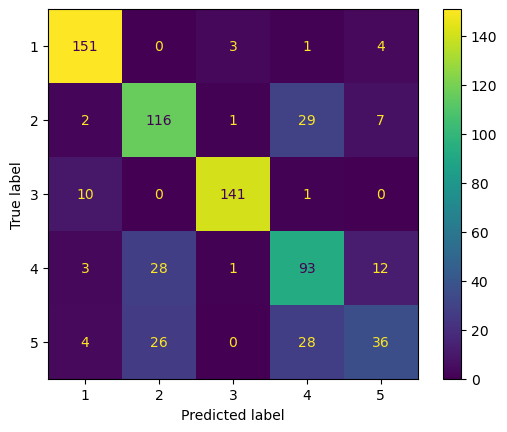

Accuracy Random Forest Classifier:  0.7704447632711621


In [24]:
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rf)
plt.show()

acc_rf = accuracy_score(Y_val, y_pred_rf)
print("Accuracy Random Forest Classifier: ", acc_rf)

# Step 4. Artificial Nueral Network (ANN) classification

In [25]:
number_samples = X_train.shape[0]
X_train_nn= np.zeros((number_samples,  kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train_nn[i,:] = np.reshape(X_train[i,:], (  kernel*kernel,bands))
    X_train_nn[i,:]= np.array(pd.DataFrame(X_train_nn[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_train_nn.shape)

Post-processed S2_train data shape:  (2784, 576, 45)


In [26]:
number_samples = X_val.shape[0]
X_val_nn= np.zeros((number_samples,   kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_val_nn[i,:] = np.reshape(X_val[i,:], (  kernel*kernel,bands))
    X_val_nn[i,:]= np.array(pd.DataFrame(X_val_nn[i,:]).fillna(0))
print("Post-processed S2_val data shape: ", X_val_nn.shape)

Post-processed S2_val data shape:  (697, 576, 45)


In [27]:
number_samples = X_test.shape[0]
X_test_nn= np.zeros((number_samples,   kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_test_nn[i,:] = np.reshape(X_test[i,:], (  kernel*kernel,bands))
    X_test_nn[i,:]= np.array(pd.DataFrame(X_test_nn[i,:]).fillna(0))
print("Post-processed S2_test data shape: ", X_test_nn.shape)

Post-processed S2_test data shape:  (490, 576, 45)


In [28]:

number_samples = X_train.shape[0]
X_train_nn2= np.zeros((number_samples,  minkernel,minkernel,bands), dtype=float)
for i in range(0,number_samples-1):
    for j in range(0,45):
        tile= np.array(X_train[i,:,:,j])
        X_train_nn2[i,:,:,j]= scipy.ndimage.zoom(tile, 1.5, order=1)
print("Post-processed S2_train data shape: ", X_train_nn2.shape)

Post-processed S2_train data shape:  (2784, 36, 36, 45)


In [29]:

number_samples = X_val.shape[0]
X_val_nn2= np.zeros((number_samples,  minkernel,minkernel,bands), dtype=float)
for i in range(0,number_samples-1):
    for j in range(0,45):
        tile= np.array(X_val[i,:,:,j])
        X_val_nn2[i,:,:,j]= scipy.ndimage.zoom(tile, 1.5, order=1)
print("Post-processed S2_train data shape: ", X_val_nn2.shape)

Post-processed S2_train data shape:  (697, 36, 36, 45)


In [30]:

number_samples = X_test.shape[0]
X_test_nn2= np.zeros((number_samples,  minkernel,minkernel,bands), dtype=float)
for i in range(0,number_samples-1):
    for j in range(0,45):
        tile= np.array(X_test[i,:,:,j])
        X_test_nn2[i,:,:,j]= scipy.ndimage.zoom(tile, 1.5, order=1)
print("Post-processed S2_train data shape: ", X_test_nn2.shape)

Post-processed S2_train data shape:  (490, 36, 36, 45)


In [31]:
base_model =tf.keras.applications.MobileNetV2(
                                               include_top=False,
                                               weights='imagenet',
                                               input_tensor=None,input_shape=(  minkernel,minkernel,3), pooling=None, classes=output_size)
   
    

base_model.trainable = False
base_learning_rate = 0.0001

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-07 01:04:13.267339: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-07 01:04:13.268630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [32]:
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

In [33]:
EarlyStopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.005,
    patience=20,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False
    #start_from_epoch=10
)
EarlyStopping2=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.005,
    patience=10,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False
    #start_from_epoch=10
)
EarlyStopping3=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.005,
    patience=5,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False
    #start_from_epoch=10
)

In [34]:
simple_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=input_size),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(output_size, activation='softmax')
])

simple_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
history = simple_model.fit(X_train_nn2, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20),EarlyStopping],  verbose=0,validation_data=(X_val_nn2, Y_val))

Epoch 1/100


2023-02-07 01:04:23.722134: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-07 01:04:23.939297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:04:26.834325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 4s 41ms/sample - loss: 5.2342 - accuracy: 0.3631 - val_loss: 1.2390 - val_accuracy: 0.4103
Epoch 21/100
87/87 [==============================] - 2s 24ms/sample - loss: 1.2917 - accuracy: 0.3901 - val_loss: 1.1335 - val_accuracy: 0.4663
Epoch 41/100
87/87 [==============================] - 2s 24ms/sample - loss: 1.2977 - accuracy: 0.3886 - val_loss: 1.1128 - val_accuracy: 0.5007
Epoch 61/100
87/87 [==============================] - 2s 24ms/sample - loss: 1.2619 - accuracy: 0.4005 - val_loss: 1.0983 - val_accuracy: 0.4290


In [36]:
y_pred_dl_p = simple_model.predict(X_val_nn2)

print("Prediction example: ", y_pred_dl_p[0,:], " Class: ", np.argmax(y_pred_dl_p[0,:]))

11/22 [==============>...............] - ETA: 0s

2023-02-07 01:08:00.417150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 17ms/step
Prediction example:  [0.00596368 0.12439887 0.3069574  0.06927263 0.27519768 0.21820976]  Class:  2


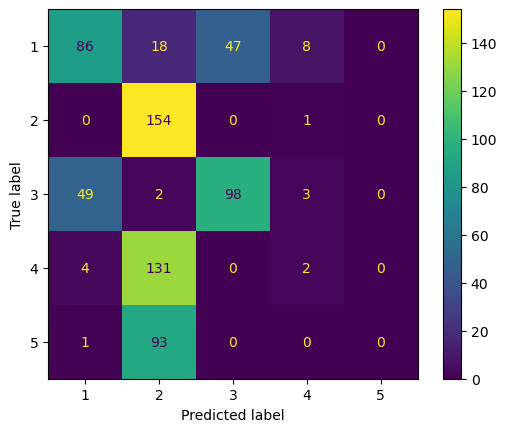

Accuracy Simple Deep Learning model:  0.4878048780487805


In [37]:
y_pred_dl = np.argmax(y_pred_dl_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_dl)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_dl)
print("Accuracy Simple Deep Learning model: ", acc_dl)

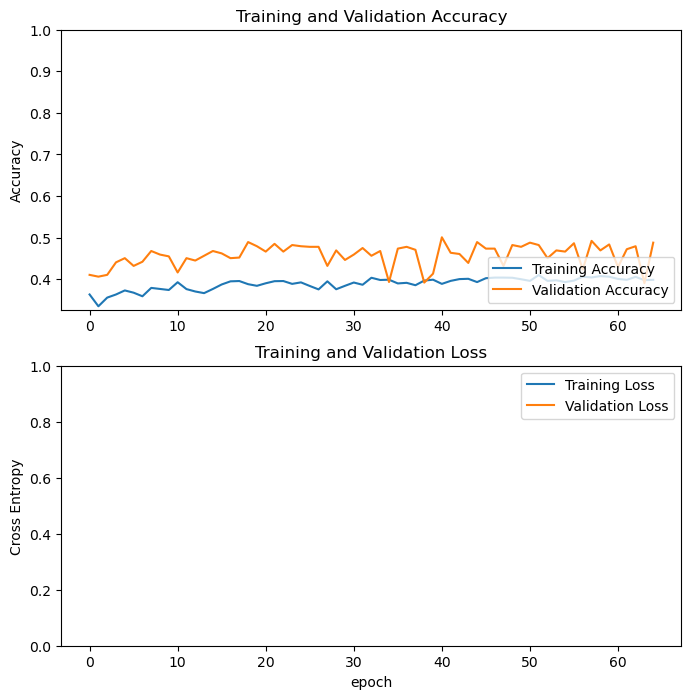

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

simple_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
simple_model.summary()
len(simple_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 58320)             0         
                                                                 
 dense (Dense)               (None, 128)               7465088   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 7,465,862
Trainable params: 7,465,862
Non-trainable params: 0
_________________________________________________________________


4

In [40]:
fine_tune_epochs = 10
initial_epochs = max(history.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = simple_model.fit(X_train_nn2,Y_train,
                         epochs=total_epochs,callbacks=[EarlyStopping2],
                         initial_epoch=history.epoch[-1],
                         validation_data=(X_val_nn2,Y_val))

Epoch 65/74


/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-02-07 01:08:12.178971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/87 [============================>.] - ETA: 0s - loss: 1.2438 - accuracy: 0.4084

2023-02-07 01:08:15.166185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 4s 36ms/step - loss: 1.2434 - accuracy: 0.4102 - val_loss: 1.0818 - val_accuracy: 0.4849
Epoch 66/74
87/87 [==============================] - 2s 27ms/step - loss: 1.2413 - accuracy: 0.4177 - val_loss: 1.0824 - val_accuracy: 0.4849
Epoch 67/74
87/87 [==============================] - 2s 27ms/step - loss: 1.2363 - accuracy: 0.4174 - val_loss: 1.0819 - val_accuracy: 0.4892
Epoch 68/74
87/87 [==============================] - 2s 27ms/step - loss: 1.2350 - accuracy: 0.4174 - val_loss: 1.0824 - val_accuracy: 0.4878
Epoch 69/74
87/87 [==============================] - 2s 27ms/step - loss: 1.2226 - accuracy: 0.4213 - val_loss: 1.0822 - val_accuracy: 0.4892
Epoch 70/74
87/87 [==============================] - 2s 27ms/step - loss: 1.2323 - accuracy: 0.4203 - val_loss: 1.0828 - val_accuracy: 0.4878
Epoch 71/74
87/87 [==============================] - 2s 27ms/step - loss: 1.2369 - accuracy: 0.4156 - val_loss: 1.0824 - val_accuracy: 0.4907
Epoch 72/74
87/87 

In [41]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

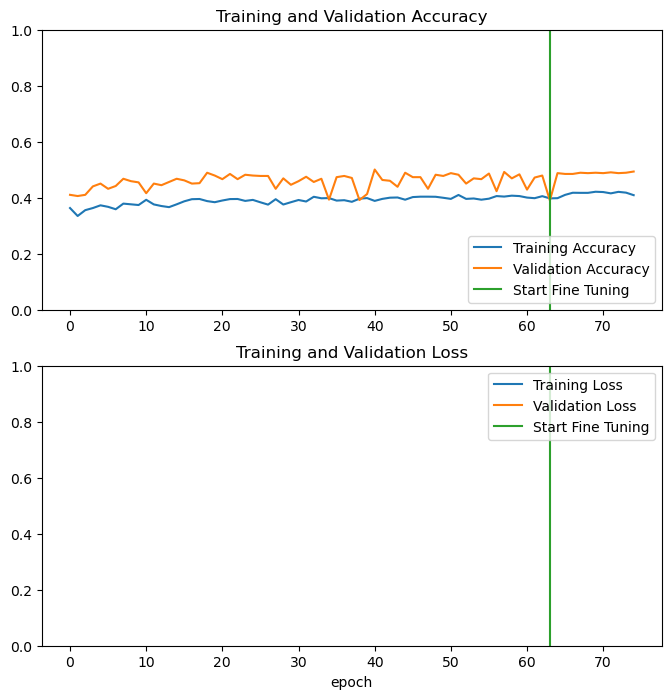

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
loss, accuracy = simple_model.evaluate(X_val_nn2,Y_val)
print('Test accuracy :', accuracy)

22/22 [==============================] - 0s 18ms/step - loss: 1.0824 - accuracy: 0.4935
Test accuracy : 0.4935437738895416


# Step 5. Convolutional Neural Networks (CNNs) classification

Convolutional Neural Networks (CNNs): These are commonly used for image classification tasks and have been shown to be effective for tree species classification using Sentinel-2 imagery.

In [45]:
CNNs_model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=input_size),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(128, (1,1), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16)
    
]
)

In [46]:

CNNs_model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 36, 32)        12992     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 18, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         8320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)       

In [47]:

CNNs_model.add(layers.Flatten())
CNNs_model.add(layers.Dense(64, activation='relu'))
CNNs_model.add(layers.Dropout(0.5))
CNNs_model.add(layers.Dense(output_size))

In [48]:

CNNs_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 36, 32)        12992     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 18, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         8320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)       

In [49]:

CNNs_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = CNNs_model.fit(X_train_nn2, Y_train, epochs=50,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=10),EarlyStopping2],  verbose=0,
                    validation_data=(X_val_nn2, Y_val))
     

Epoch 1/50


2023-02-07 01:09:31.894472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:09:33.921453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 2s 28ms/sample - loss: 1.4052 - accuracy: 0.3409 - val_loss: 1.0726 - val_accuracy: 0.4290
Epoch 11/50
87/87 [==============================] - 1s 13ms/sample - loss: 0.8125 - accuracy: 0.6254 - val_loss: 0.7335 - val_accuracy: 0.5940
Epoch 21/50
87/87 [==============================] - 1s 13ms/sample - loss: 0.6822 - accuracy: 0.6915 - val_loss: 0.7169 - val_accuracy: 0.6700


In [50]:
y_pred_cnn_p = CNNs_model.predict(X_val_nn2)

print("Prediction example: ", y_pred_cnn_p[0,:], " Class: ", np.argmax(y_pred_cnn_p[0,:]))

11/22 [==============>...............] - ETA: 0s

2023-02-07 01:11:55.677461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 11ms/step
Prediction example:  [-4.8456607 -0.6465894  1.2709574 -2.5406375  1.5667404  1.5758634]  Class:  5


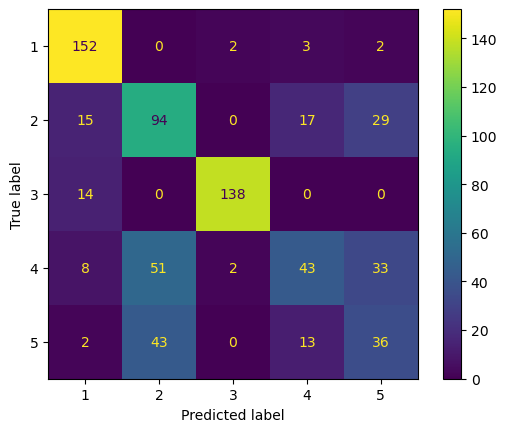

Accuracy Simple Deep Learning model:  0.6642754662840746


In [51]:
y_pred_cnn = np.argmax(y_pred_cnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_cnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_cnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

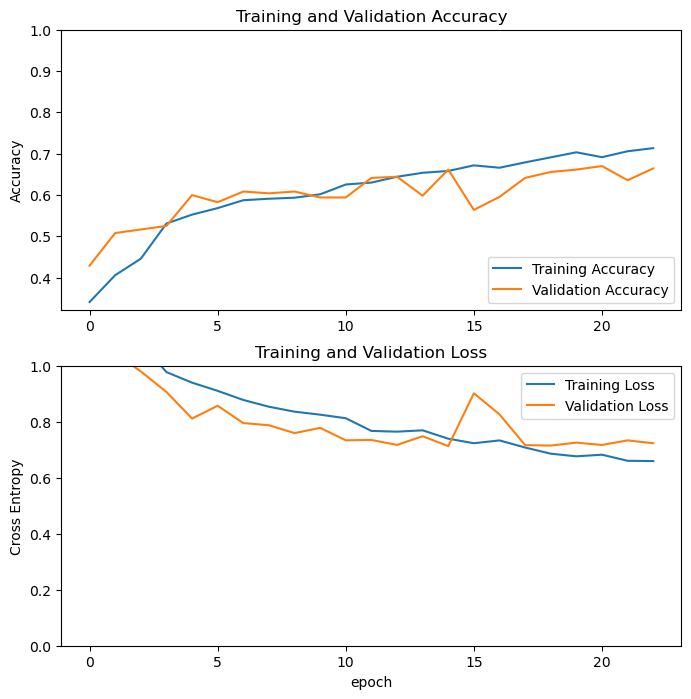

In [52]:

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [53]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

CNNs_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
CNNs_model.summary()
len(CNNs_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 36, 32)        12992     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 18, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         8320      
                                                                 
 max_pooling2

14

In [54]:

fine_tune_epochs = 10
initial_epochs = max(history2.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = CNNs_model.fit(X_train_nn2,Y_train,
                         epochs=total_epochs,callbacks=EarlyStopping3,
                         initial_epoch=history2.epoch[-1],
                         validation_data=(X_val_nn2,Y_val))

Epoch 23/32


2023-02-07 01:12:14.545240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - ETA: 0s - loss: 0.5851 - accuracy: 0.7478

2023-02-07 01:12:16.551198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 3s 21ms/step - loss: 0.5851 - accuracy: 0.7478 - val_loss: 0.6987 - val_accuracy: 0.6628
Epoch 24/32
87/87 [==============================] - 1s 16ms/step - loss: 0.5667 - accuracy: 0.7626 - val_loss: 0.6961 - val_accuracy: 0.6657
Epoch 25/32
87/87 [==============================] - 1s 16ms/step - loss: 0.5659 - accuracy: 0.7529 - val_loss: 0.6957 - val_accuracy: 0.6686
Epoch 26/32
87/87 [==============================] - 1s 17ms/step - loss: 0.5604 - accuracy: 0.7586 - val_loss: 0.6966 - val_accuracy: 0.6714
Epoch 27/32
87/87 [==============================] - 1s 15ms/step - loss: 0.5605 - accuracy: 0.7647 - val_loss: 0.6970 - val_accuracy: 0.6714
Epoch 28/32
87/87 [==============================] - 1s 16ms/step - loss: 0.5513 - accuracy: 0.7619 - val_loss: 0.6976 - val_accuracy: 0.6714


In [55]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

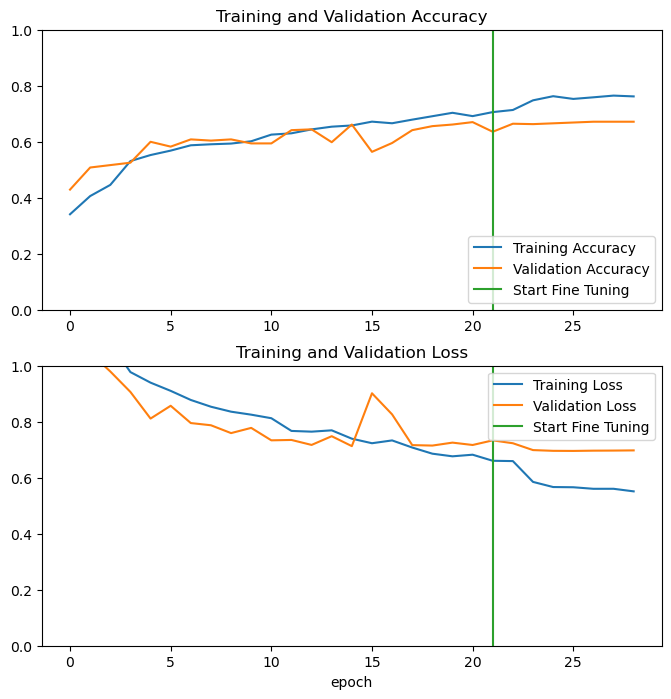

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [57]:
loss, accuracy = CNNs_model.evaluate(X_val_nn2,Y_val)
print('Test accuracy :', accuracy)

22/22 [==============================] - 0s 10ms/step - loss: 0.6976 - accuracy: 0.6714
Test accuracy : 0.6714490652084351


# Step 6. - Residual Network: ResNet

A residual neural network (ResNet) is an artificial neural network that imitate the pyramidal cells in the cerebral cortex. Particularly, the ResNet architecture consists of skip connections or shortcuts to jump over some layers. Typical ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between. These *cells* are known as *residual block*.

ResNets connection weights are easier to optimize (especially for gradient descent-based optimizers) because the short cuts contribute to alleviate the vanishing gradient problem.

In practice, the degradation problem (i.e., increasing the depth of a network leads to a decrease in its performance) is mitigated, and the observed performance (when the number of hidden layers increase) is much closer to the theoretical one.

In [58]:
model_rn = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_size, 
    pooling=None,
    classes=output_size)

model_rn.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/applications/resnet.py:159: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 45 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


In [59]:
history3=model_rn.fit(X_train_nn2, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=10),EarlyStopping],  verbose=0,validation_data=(X_val_nn2, Y_val))


Epoch 1/100


2023-02-07 01:12:42.682744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:12:53.609877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 15s 169ms/sample - loss: 1.5958 - accuracy: 0.4781 - val_loss: 1.5691 - val_accuracy: 0.3400
Epoch 11/100
87/87 [==============================] - 7s 78ms/sample - loss: 0.9446 - accuracy: 0.5930 - val_loss: 19.2537 - val_accuracy: 0.3902
Epoch 21/100
87/87 [==============================] - 7s 77ms/sample - loss: 0.5306 - accuracy: 0.7981 - val_loss: 0.9442 - val_accuracy: 0.6456
Epoch 31/100
87/87 [==============================] - 7s 77ms/sample - loss: 0.3122 - accuracy: 0.8854 - val_loss: 1.2307 - val_accuracy: 0.5997
Epoch 41/100
87/87 [==============================] - 7s 77ms/sample - loss: 0.1456 - accuracy: 0.9447 - val_loss: 1.2443 - val_accuracy: 0.6772


2023-02-07 01:18:21.483242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 35ms/step


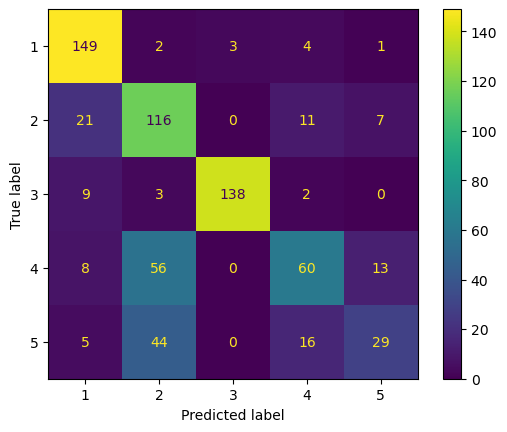

Accuracy ResNet-50 model:  0.7058823529411765


In [60]:
y_pred_rn_p = model_rn.predict(X_val_nn2)

y_pred_rn = np.argmax(y_pred_rn_p, axis=1)

##print(y_pred_rn)
#print(Y_val)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rn)
plt.show()

acc_rn = accuracy_score(Y_val, y_pred_rn)
print("Accuracy ResNet-50 model: ", acc_rn)

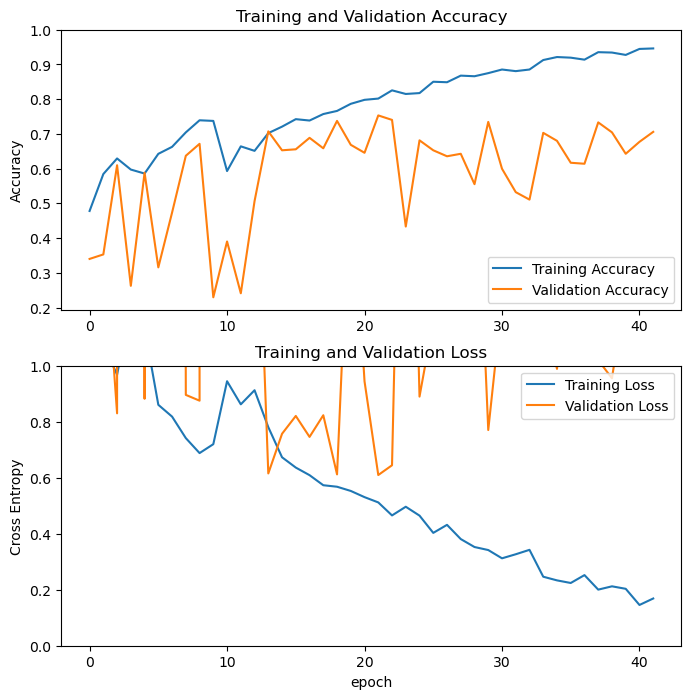

In [61]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [62]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model_rn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model_rn.summary()
len(model_rn.trainable_variables)

Number of layers in the base model:  154
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 36, 36, 45)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 42, 42, 45)   0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 18, 18, 64)   141184      ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 18, 18, 64)

214

In [63]:
fine_tune_epochs = 10
initial_epochs = max(history3.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model_rn.fit(X_train_nn2,Y_train,
                         epochs=total_epochs, callbacks=EarlyStopping3,
                         initial_epoch=history3.epoch[-1],
                         validation_data=(X_val_nn2,Y_val))

Epoch 42/51


/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-02-07 01:18:37.793409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.9698

2023-02-07 01:19:04.221745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 32s 186ms/step - loss: 0.1045 - accuracy: 0.9698 - val_loss: 0.9480 - val_accuracy: 0.7561
Epoch 43/51
87/87 [==============================] - 12s 133ms/step - loss: 0.0825 - accuracy: 0.9749 - val_loss: 0.9437 - val_accuracy: 0.7590
Epoch 44/51
87/87 [==============================] - 11s 129ms/step - loss: 0.0698 - accuracy: 0.9763 - val_loss: 0.9420 - val_accuracy: 0.7633
Epoch 45/51
87/87 [==============================] - 12s 134ms/step - loss: 0.0623 - accuracy: 0.9824 - val_loss: 0.9473 - val_accuracy: 0.7618
Epoch 46/51
87/87 [==============================] - 12s 141ms/step - loss: 0.0735 - accuracy: 0.9835 - val_loss: 0.9669 - val_accuracy: 0.7661
Epoch 47/51
87/87 [==============================] - 12s 142ms/step - loss: 0.0688 - accuracy: 0.9817 - val_loss: 0.9876 - val_accuracy: 0.7733


In [64]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

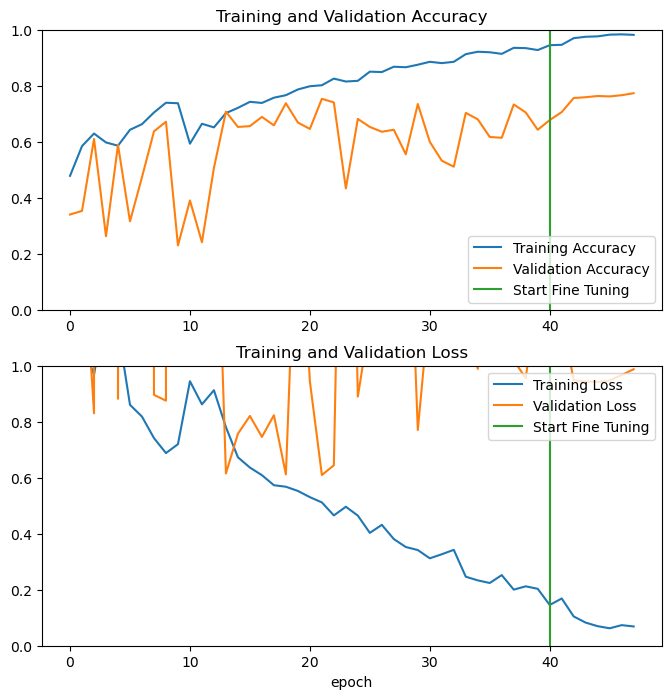

In [65]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [66]:
loss, accuracy = model_rn.evaluate(X_val_nn2,Y_val)
print('Test accuracy :', accuracy)

22/22 [==============================] - 1s 33ms/step - loss: 0.9876 - accuracy: 0.7733
Test accuracy : 0.7733142375946045


# Step 7. Recurrent Neural Networks (RNNs) classification

Recurrent Neural Networks (RNNs): RNNs can be used to analyze sequential data such as time series data, which can be useful for analyzing the temporal information present in Sentinel-2 imagery.

In [67]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = bands

units = 64


# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(kernel*kernel, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(kernel*kernel, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model

In [68]:
RNNs_model = build_model(allow_cudnn_kernel=True)

RNNs_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


history5=RNNs_model.fit(
    X_train_nn, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=10),EarlyStopping],  verbose=0, validation_data=(X_val_nn, Y_val), batch_size=batch_size
)

Epoch 1/100


2023-02-07 01:20:58.017439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:20:58.191093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:21:00.186951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:21:17.307697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:21:17.390602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 24s 534ms/sample - loss: 1.4556 - accuracy: 0.4149 - val_loss: 1.6576 - val_accuracy: 0.4175
Epoch 11/100
44/44 [==============================] - 7s 164ms/sample - loss: 1.0682 - accuracy: 0.5747 - val_loss: 1.9311 - val_accuracy: 0.3199
Epoch 21/100
44/44 [==============================] - 7s 165ms/sample - loss: 0.9888 - accuracy: 0.6128 - val_loss: 1.6870 - val_accuracy: 0.4390
Epoch 31/100
44/44 [==============================] - 7s 164ms/sample - loss: 0.9467 - accuracy: 0.6167 - val_loss: 3.0697 - val_accuracy: 0.2568
Epoch 41/100
44/44 [==============================] - 7s 165ms/sample - loss: 0.9350 - accuracy: 0.6225 - val_loss: 1.2028 - val_accuracy: 0.5552


In [69]:
y_pred_rnn_p = RNNs_model.predict(X_val_nn)

print("Prediction example: ", y_pred_rnn_p[0,:], " Class: ", np.argmax(y_pred_rnn_p[0,:]))

2023-02-07 01:26:38.864110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:26:38.922827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 5s 151ms/step
Prediction example:  [-3.6101136 -3.2619028  1.3446776 -6.673214  -1.4961548 -4.6132574]  Class:  2


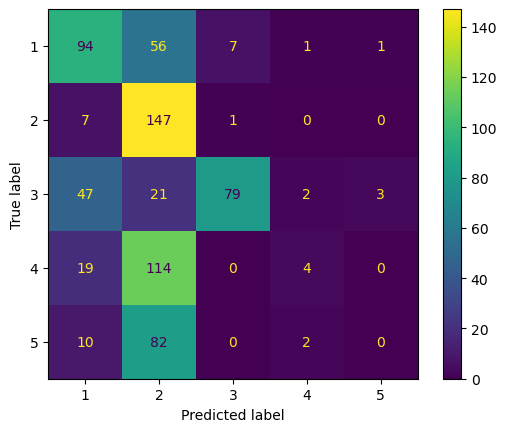

Accuracy Simple Deep Learning model:  0.4648493543758967


In [70]:
y_pred_rnn = np.argmax(y_pred_rnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_rnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

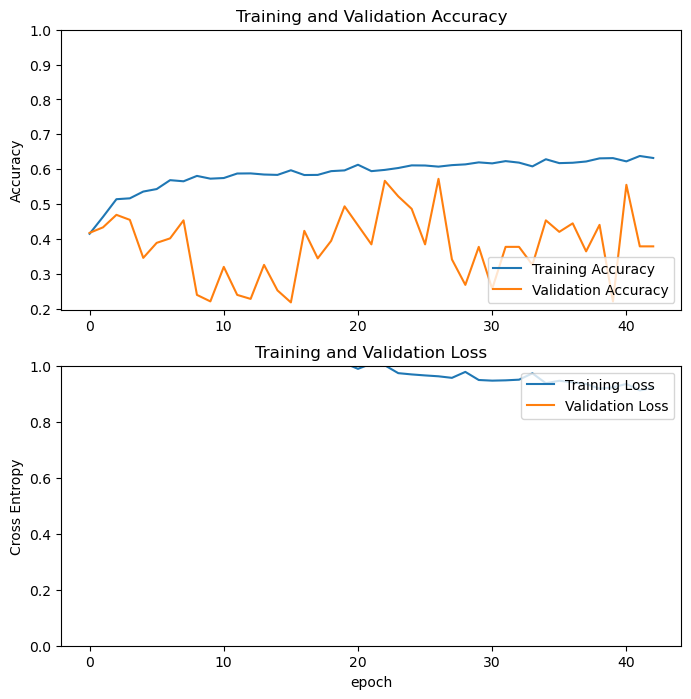

In [71]:

acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [72]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

RNNs_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
RNNs_model.summary()
len(RNNs_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                28160     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_6 (Dense)             (None, 6)                 390       
                                                                 
Total params: 28,806
Trainable params: 28,678
Non-trainable params: 128
_________________________________________________________________


7

In [73]:
fine_tune_epochs = 15
initial_epochs = max(history5.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = RNNs_model.fit(X_train_nn,Y_train,
                         epochs=total_epochs, callbacks=EarlyStopping2,
                         initial_epoch=history5.epoch[-1],
                         validation_data=(X_val_nn,Y_val))

Epoch 43/57


2023-02-07 01:26:55.484455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:26:55.655862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:26:57.407651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - ETA: 0s - loss: 1.1621 - accuracy: 0.5409

2023-02-07 01:27:14.581376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:27:14.662327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 24s 197ms/step - loss: 1.1621 - accuracy: 0.5409 - val_loss: 1.1693 - val_accuracy: 0.5380
Epoch 44/57
87/87 [==============================] - 14s 159ms/step - loss: 1.0903 - accuracy: 0.5715 - val_loss: 1.0503 - val_accuracy: 0.5681
Epoch 45/57
87/87 [==============================] - 14s 159ms/step - loss: 1.0402 - accuracy: 0.5855 - val_loss: 1.0075 - val_accuracy: 0.5868
Epoch 46/57
87/87 [==============================] - 14s 159ms/step - loss: 1.0181 - accuracy: 0.5930 - val_loss: 0.9782 - val_accuracy: 0.6069
Epoch 47/57
87/87 [==============================] - 14s 159ms/step - loss: 0.9996 - accuracy: 0.5941 - val_loss: 0.9547 - val_accuracy: 0.6098
Epoch 48/57
87/87 [==============================] - 14s 159ms/step - loss: 0.9721 - accuracy: 0.6106 - val_loss: 0.9392 - val_accuracy: 0.6255
Epoch 49/57
87/87 [==============================] - 14s 159ms/step - loss: 0.9683 - accuracy: 0.6110 - val_loss: 0.9264 - val_accuracy: 0.6341
Epoc

In [74]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

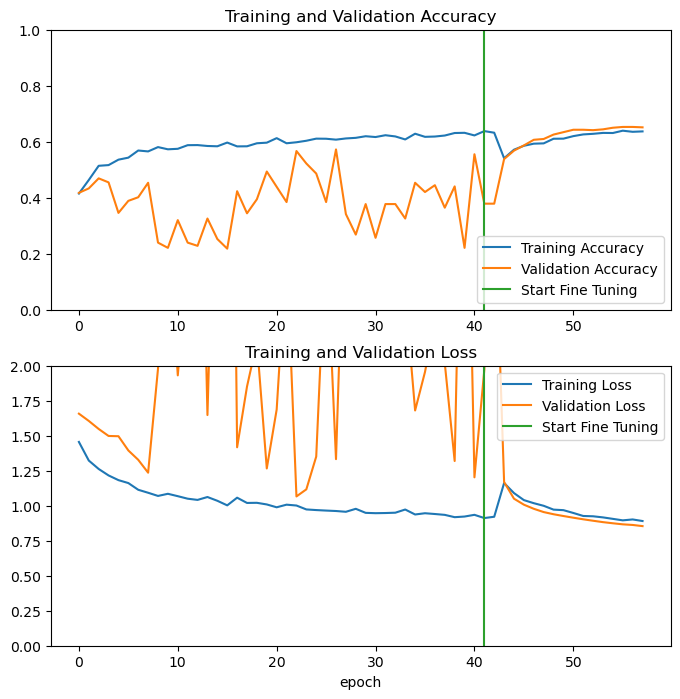

In [75]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [76]:
loss, accuracy = RNNs_model.evaluate(X_val_nn,Y_val)
print('Test accuracy :', accuracy)

22/22 [==============================] - 2s 89ms/step - loss: 0.8544 - accuracy: 0.6514
Test accuracy : 0.6513630151748657


# Step 8. Decision fusion for deep learning methods

In [77]:
def normalized(data):

    normalizedData = data/np.linalg.norm(data)
    return normalizedData

In [78]:

y_pred_dl_p_2 = simple_model.predict(X_val_nn2)
y_pred_cnn_p_2 = CNNs_model.predict(X_val_nn2)
y_pred_rn_p_2 = model_rn.predict(X_val_nn2)
y_pred_rnn_p_2 = RNNs_model.predict(X_val_nn)

 6/22 [=======>......................] - ETA: 0s

2023-02-07 01:31:07.674677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 2/22 [=>............................] - ETA: 2s

2023-02-07 01:31:08.465856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 23ms/step


2023-02-07 01:31:09.716578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 2s 40ms/step


2023-02-07 01:31:11.248338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:31:11.302446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 5s 148ms/step


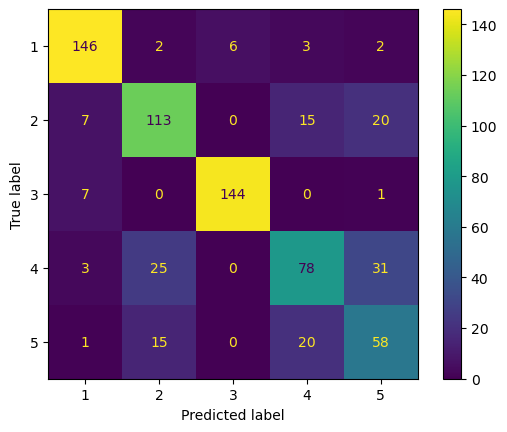

Accuracy Simple Deep Learning model:  0.7733142037302726


In [79]:

#fusion"""y_pred_dl_p_2 +
fusion_softmax = normalized(y_pred_cnn_p_2) + normalized(y_pred_rn_p_2) + normalized(y_pred_rnn_p_2)
fusion_label = np.argmax(fusion_softmax,axis=1).astype(np.int16)
ConfusionMatrixDisplay.from_predictions(Y_val, fusion_label)
plt.show()

acc_dl = accuracy_score(Y_val, fusion_label)
print("Accuracy Simple Deep Learning model: ", acc_dl)

# Step 9. Test data prediction

16/16 [==============================] - 3s 174ms/step


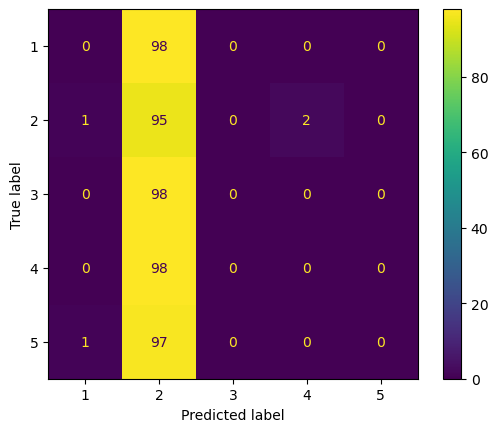

Accuracy Simple Deep Learning model:  0.19387755102040816


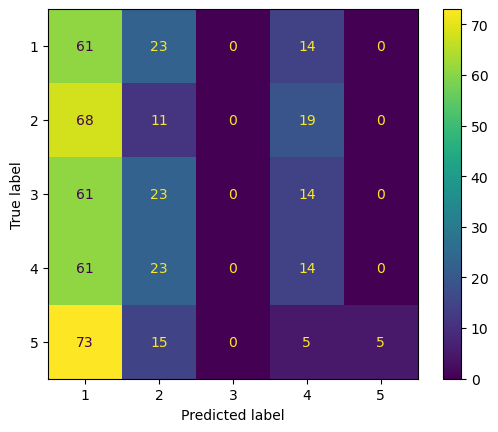

Accuracy Convolutional Neural Network model:  0.18571428571428572


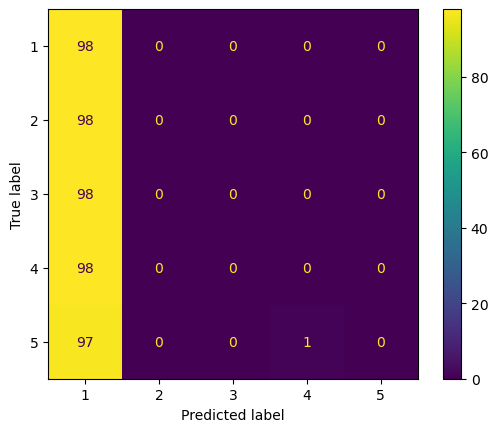

Accuracy Resnet50 model:  0.2


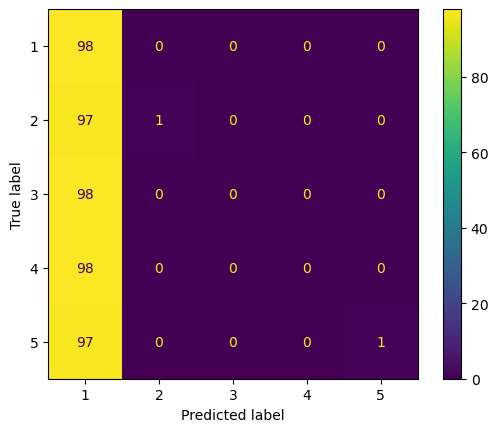

Accuracy RNN model:  0.20408163265306123


In [80]:
y_pred_dl_p_3 = simple_model.predict(X_test_nn2)
y_pred_cnn_p_3 = CNNs_model.predict(X_test_nn2)
y_pred_rn_p_3 = model_rn.predict(X_test_nn2)
y_pred_rnn_p_3 = RNNs_model.predict(X_test_nn)
y_pred_dl_3 = np.argmax(y_pred_dl_p_3,axis=1).astype(np.int16)
y_pred_cnn_3 = np.argmax(y_pred_cnn_p_3,axis=1).astype(np.int16)
y_pred_rn_3 = np.argmax(y_pred_rn_p_3,axis=1).astype(np.int16)
y_pred_rnn_3 = np.argmax(y_pred_rnn_p_3,axis=1).astype(np.int16)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_dl_3)
plt.show()
acc_dl_3 = accuracy_score(Y_test, y_pred_dl_3)
print("Accuracy Simple Deep Learning model: ", acc_dl_3)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_cnn_3)
plt.show()
acc_cnn_3 = accuracy_score(Y_test, y_pred_cnn_3)
print("Accuracy Convolutional Neural Network model: ", acc_cnn_3)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_rn_3)
plt.show()
acc_rn_3 = accuracy_score(Y_test, y_pred_rn_3)
print("Accuracy Resnet50 model: ", acc_rn_3)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_rnn_3)
plt.show()
acc_rnn_3 = accuracy_score(Y_test, y_pred_rnn_3)
print("Accuracy RNN model: ", acc_rnn_3)

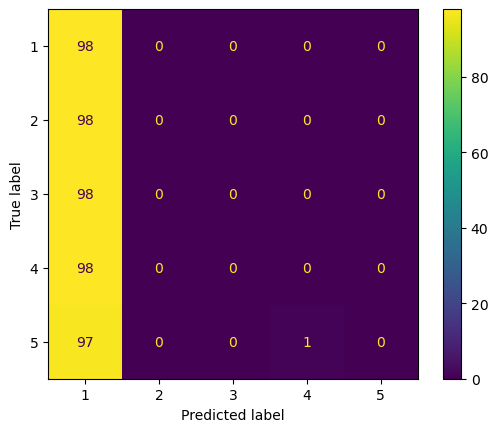

Accuracy Simple Deep Learning model:  0.2


In [81]:
#fusion"""y_pred_dl_p_2 +
fusion_softmax_t = normalized(y_pred_cnn_p_3)  + normalized(y_pred_rn_p_3) + normalized(y_pred_rnn_p_3)
fusion_label_t = np.argmax(fusion_softmax_t,axis=1).astype(np.int16)
ConfusionMatrixDisplay.from_predictions(Y_test, fusion_label_t)
plt.show()

acc_dl = accuracy_score(Y_test, fusion_label_t)
print("Accuracy Simple Deep Learning model: ", acc_dl)